In [1757]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import debug
import cv2

In [1758]:
SIZE = 700

image = cv2.imread("../images/boards/yellow_black_up.jpeg")
image_size = (SIZE,SIZE)
image = cv2.resize(image,image_size)

In [1759]:
def _detect_edges(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 90, 400, 3)
    return edges

edges_image = _detect_edges(image)

In [1760]:
HOUGH_THRESHOLD = 100
THETA_RESOLUTION = np.pi / 180
RHO_RESOLUTION = 1

def _generate_edges_lines(canny):
    
    lines = cv2.HoughLines(canny, 
                            rho = RHO_RESOLUTION, 
                            theta =  THETA_RESOLUTION, 
                            threshold = HOUGH_THRESHOLD)
    
    #Format dataset
    lines = lines.reshape(len(lines),2)
    
    coor_lines = []
    for line in lines:
        rho,theta = line
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 +1000*(-b))
        y1 = int(y0 +1000*(a))
        x2 = int(x0 -1000*(-b))
        y2 = int(y0 -1000*(a))   
        coor_lines.append(((x1,y1),(x2,y2)))
    
    return np.array(coor_lines)
    
lines = _generate_edges_lines(edges_image)

In [1761]:
from sklearn.cluster import KMeans

CLUSTERS_N = 9

def _get_lines_means(points, direction, n_clusters = CLUSTERS_N):
    
    means = []

    for lines in points:
    
        kmeans = KMeans(n_clusters = n_clusters, n_init='auto')
        kmeans.fit(lines)
        labels = kmeans.labels_
    
        unique_labels = list(range(n_clusters))
    
        cluster_means = []
    
        for label in unique_labels: 
            cluster_data = lines[labels == label] 
            cluster_mean = np.round(sum(cluster_data)/len(cluster_data))  
            cluster_means.append(cluster_mean)
        
        cluster_means = np.array(cluster_means)
        sorted_index = np.argsort(cluster_means[:, direction])
        
        means.append(cluster_means[sorted_index])
 
    return means


In [1762]:
VERTICAL = 0
HORIZONTAL = 1

def _get_vertical_averages(lines):
    
    vertical_lines = lines[lines[:,0,1] > SIZE]
    
    initial_points = vertical_lines[:,1][vertical_lines[:,1,1] < SIZE]
    final_points = vertical_lines[:,0][vertical_lines[:,0,1] > SIZE] 
    
    averages = _get_lines_means((initial_points, final_points), VERTICAL)
    
    return np.stack(averages, axis=1)

def _get_horizontal_averages(lines):

    horizontal_lines = lines[lines[:,1,0] > SIZE]

    initial_points = horizontal_lines[:,1][horizontal_lines[:,0,0] < SIZE]
    final_points = horizontal_lines[:,0][horizontal_lines[:,1,0] > SIZE]
    
    averages = _get_lines_means((initial_points, final_points), HORIZONTAL)
    
    return np.stack(averages, axis=1)
    
vertical_lines = _get_vertical_averages(lines).astype(int)
horizontal_lines = _get_horizontal_averages(lines).astype(int)

lines = np.concatenate((vertical_lines,horizontal_lines), axis=0)

debug.lines(image,lines, size = 3)


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

Detect chesboard corners

In [1763]:
def line_intersection(lines):

    points =[]
    for i in range(len(lines)):
        for j in range(i + 1, len(lines)):

            line1 = lines[i]
            line2 = lines[j]
            xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
            ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

            def det(a, b):
                return a[0] * b[1] - a[1] * b[0]

            div = det(xdiff, ydiff)
            if div != 0:
                

                d = (det(*line1), det(*line2))
                x = det(d, xdiff) / div
                y = det(d, ydiff) / div
                points.append((x,y)) 
    return points

points = np.array(line_intersection(lines))

lower_limit = 0
upper_limit = 700

# Create a mask to filter points within the range
mask = (points[:, 0] >= lower_limit) & (points[:, 0] <= upper_limit) & \
       (points[:, 1] >= lower_limit) & (points[:, 1] <= upper_limit)
       
points = points[mask]

debug.points(image,points, color = (0,255,0), size = 7)

#print(len(sorted_intersections))

C:\Users\AMD R3\AppData\Local\Temp\ipykernel_8748\3671007147.py:13: RuntimeWarning: overflow encountered in scalar multiply
  return a[0] * b[1] - a[1] * b[0]
C:\Users\AMD R3\AppData\Local\Temp\ipykernel_8748\3671007147.py:13: RuntimeWarning: overflow encountered in scalar subtract
  return a[0] * b[1] - a[1] * b[0]


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

Trim image

In [1764]:
vertex = np.array(sorted_intersections, np.int32)
black_mask = np.zeros_like(image)
cv2.fillPoly(black_mask, [vertex], (255, 255, 255))
trimmed_image = cv2.bitwise_and(image, black_mask)

Detect inner corners

In [1765]:
gray_trimmed_image = cv2.cvtColor(trimmed_image, cv2.COLOR_BGR2GRAY)
max_corners = 80
corners = cv2.goodFeaturesToTrack(gray_trimmed_image, max_corners, qualityLevel= 0.1, minDistance= 15)
corners = np.intp(corners)
actual_size = corners.shape[0], corners.shape[2]
corners = corners.reshape(actual_size)

debug.points(trimmed_image,corners, color=(0,255,0), size= 5);

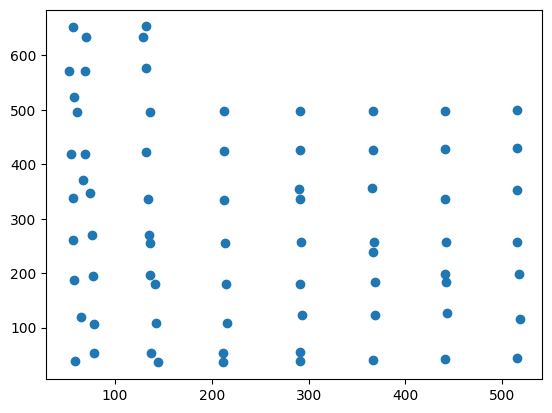

In [1766]:
plt.scatter(corners[:,0], corners[:,1])

In [1767]:
cv2.imshow('Imagen Original', image)
cv2.imshow('canny', canny)
#cv2.imshow('Imagen Recortada', trimmed_image)
cv2.waitKey(0)
cv2.destroyAllWindows()